In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0


In [2]:
import os
import cv2

dataset_path = r"DATASET-20251202T142134Z-1-001/DATASET"

classes = os.listdir(dataset_path)
print("Classes found:", classes)

data = []
labels = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                data.append(img)
                labels.append(cls)

print("Total images loaded:", len(data))

Classes found: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']
Total images loaded: 1203


In [3]:
from collections import Counter

class_counts = Counter(labels)  

print(class_counts)


Counter({'dark spots': 303, 'clear skin': 300, 'puffy eyes': 300, 'wrinkles': 300})


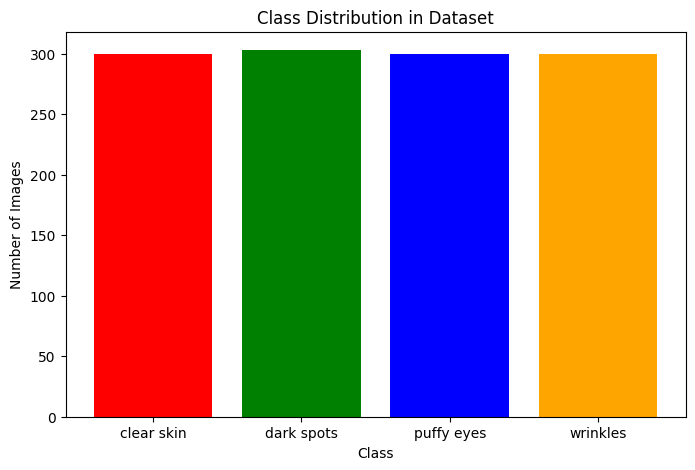

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
colors = ['red', 'green', 'blue', 'orange']  
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
import cv2
import numpy as np

IMG_SIZE = 224
processed_images = []

for img in data: 
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    normalized = resized / 255.0
    processed_images.append(normalized)

processed_images = np.array(processed_images)

print("Processed images shape:", processed_images.shape)


Processed images shape: (1203, 224, 224, 3)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,     
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.2,        
    horizontal_flip=True,  
    fill_mode='nearest'
)


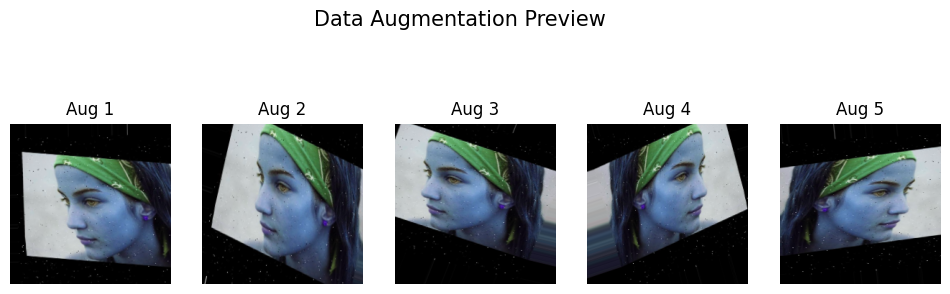

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

random_index = random.randrange(len(processed_images))
selected_image = processed_images[random_index]

# Prepare image for augmentation
image_array = np.expand_dims(selected_image, axis=0)

# Generate 5 augmented versions
augmented_batch = [next(datagen.flow(image_array))[0] for _ in range(5)]

# Plot results
plt.figure(figsize=(12, 4))

for i, img in enumerate(augmented_batch):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Aug {i+1}")

plt.suptitle("Data Augmentation Preview", fontsize=15)
plt.show()


In [9]:
print("Unique labels:", set(labels))
print("Classes:", classes)


Unique labels: {'dark spots', 'wrinkles', 'clear skin', 'puffy eyes'}
Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [10]:
from tensorflow.keras.utils import to_categorical


label_map = {cls: i for i, cls in enumerate(classes)}
print("Label Mapping:", label_map)


numeric_labels = [label_map[label] for label in labels]


num_classes = len(classes)
labels_one_hot = to_categorical(numeric_labels, num_classes)

print("One-hot encoded shape:", labels_one_hot.shape)
print(labels_one_hot[:5])

Label Mapping: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}
One-hot encoded shape: (1203, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [20]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt


In [21]:
# CHANGE ONLY THIS PATH IF NEEDED
DATASET_PATH = r"DATASET-20251202T142134Z-1-001/DATASET"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
SEED = 123
EPOCHS = 50


In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 1203 files belonging to 4 classes.
Using 963 files for training.
Found 1203 files belonging to 4 classes.
Using 240 files for validation.
Class names: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 1203 files belonging to 4 classes.
Using 963 files for training.
Found 1203 files belonging to 4 classes.
Using 240 files for validation.
Class names: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [25]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # IMPORTANT for stability


In [26]:
model = models.Sequential([
    base_model,
    layers.Rescaling(1./255),   # normalization INSIDE model
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])


In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 7, 7, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.3406 - loss: 1.3836 - val_accuracy: 0.4250 - val_loss: 1.3812
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5327 - loss: 1.3774 - val_accuracy: 0.5958 - val_loss: 1.3762
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5846 - loss: 1.3716 - val_accuracy: 0.6250 - val_loss: 1.3715
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6854 - loss: 1.3660 - val_accuracy: 0.6667 - val_loss: 1.3669
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7134 - loss: 1.3603 - val_accuracy: 0.6417 - val_loss: 1.3625
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7331 - loss: 1.3548 - val_accuracy: 0.6583 - val_loss: 1.3575
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7352 - loss: 1.3494 - val_accuracy: 0.6583 - val_loss: 1.3528
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7175 - loss: 1.3439 - val_accuracy: 0.6458 - val_loss:

In [29]:
final_train_acc = history.history["accuracy"][-1] * 100
final_val_acc = history.history["val_accuracy"][-1] * 100

print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


Final Training Accuracy: 79.75%
Final Validation Accuracy: 79.58%


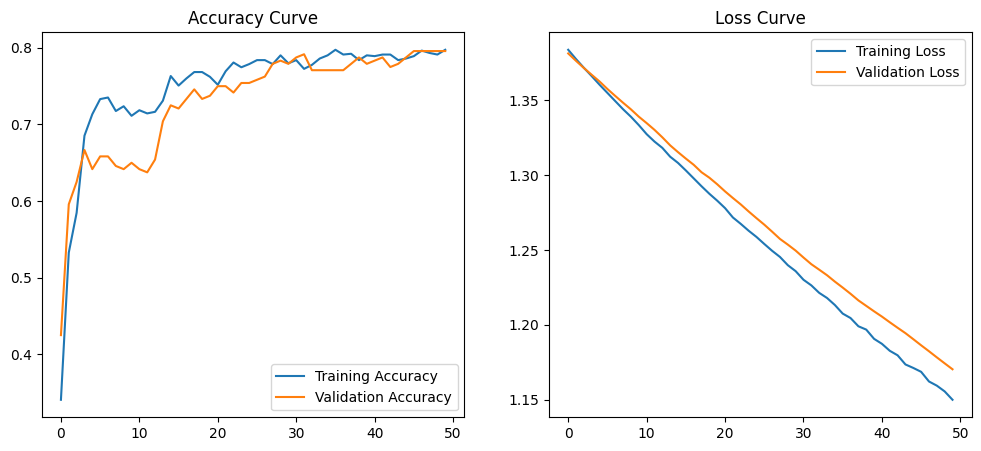

In [30]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()


In [140]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

DATASET_PATH = r"DATASET-20251202T142134Z-1-001/DATASET"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 40

In [141]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

val_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = train_gen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode="categorical"
)

class_names = list(train_data.class_indices.keys())
print("Class Names:", class_names)

Found 963 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Class Names: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [142]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze first stage

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [143]:
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=2
)

Epoch 1/20
31/31 - 51s - 2s/step - accuracy: 0.5774 - loss: 1.0368 - val_accuracy: 0.8417 - val_loss: 0.4290
Epoch 2/20
31/31 - 40s - 1s/step - accuracy: 0.7518 - loss: 0.6094 - val_accuracy: 0.8042 - val_loss: 0.4738
Epoch 3/20
31/31 - 40s - 1s/step - accuracy: 0.7809 - loss: 0.5668 - val_accuracy: 0.8500 - val_loss: 0.3736
Epoch 4/20
31/31 - 39s - 1s/step - accuracy: 0.8089 - loss: 0.5063 - val_accuracy: 0.8458 - val_loss: 0.3810
Epoch 5/20
31/31 - 39s - 1s/step - accuracy: 0.8162 - loss: 0.4480 - val_accuracy: 0.8417 - val_loss: 0.3665
Epoch 6/20
31/31 - 40s - 1s/step - accuracy: 0.8287 - loss: 0.4598 - val_accuracy: 0.8833 - val_loss: 0.3152
Epoch 7/20
31/31 - 42s - 1s/step - accuracy: 0.8401 - loss: 0.4179 - val_accuracy: 0.8917 - val_loss: 0.3107
Epoch 8/20
31/31 - 43s - 1s/step - accuracy: 0.8463 - loss: 0.3959 - val_accuracy: 0.8542 - val_loss: 0.3475
Epoch 9/20
31/31 - 41s - 1s/step - accuracy: 0.8307 - loss: 0.4666 - val_accuracy: 0.8458 - val_loss: 0.4187
Epoch 10/20
31/31 -

In [144]:
for layer in base_model.layers[-60:]:  
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=2
)

Epoch 1/20
31/31 - 80s - 3s/step - accuracy: 0.5898 - loss: 1.4452 - val_accuracy: 0.9292 - val_loss: 0.2387
Epoch 2/20
31/31 - 58s - 2s/step - accuracy: 0.6854 - loss: 0.9348 - val_accuracy: 0.9208 - val_loss: 0.2523
Epoch 3/20
31/31 - 57s - 2s/step - accuracy: 0.7404 - loss: 0.7644 - val_accuracy: 0.9208 - val_loss: 0.2680
Epoch 4/20
31/31 - 58s - 2s/step - accuracy: 0.7788 - loss: 0.6245 - val_accuracy: 0.9083 - val_loss: 0.2832
Epoch 5/20
31/31 - 60s - 2s/step - accuracy: 0.7892 - loss: 0.5794 - val_accuracy: 0.9125 - val_loss: 0.2955
Epoch 6/20
31/31 - 64s - 2s/step - accuracy: 0.8255 - loss: 0.4623 - val_accuracy: 0.9083 - val_loss: 0.2998
Epoch 7/20
31/31 - 65s - 2s/step - accuracy: 0.8328 - loss: 0.4453 - val_accuracy: 0.9125 - val_loss: 0.2952
Epoch 8/20
31/31 - 62s - 2s/step - accuracy: 0.8276 - loss: 0.4423 - val_accuracy: 0.9083 - val_loss: 0.2935
Epoch 9/20
31/31 - 58s - 2s/step - accuracy: 0.8577 - loss: 0.4040 - val_accuracy: 0.9125 - val_loss: 0.2922
Epoch 10/20
31/31 -

In [145]:
final_train = history2.history['accuracy'][-1]
final_val = history2.history['val_accuracy'][-1]

print(f" Final Training Accuracy: {final_train*100:.2f}%")
print(f" Final Validation Accuracy: {final_val*100:.2f}%")

model.save("MobileNetV2_SkinAging_Model.keras")
print("\n Model Saved Successfully!")

 Final Training Accuracy: 89.30%
 Final Validation Accuracy: 91.25%

 Model Saved Successfully!


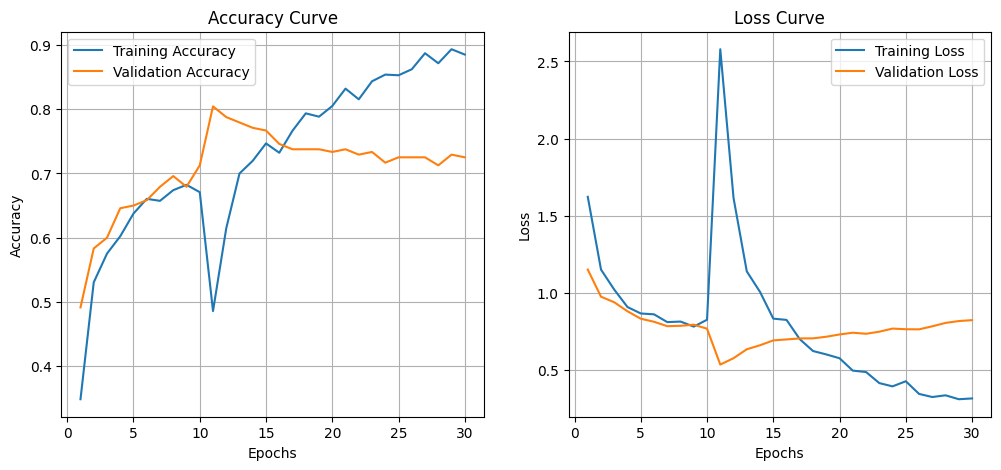

In [147]:
import matplotlib.pyplot as plt


acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# ---- Accuracy Curve ----
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# ---- Loss Curve ----
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:

import cv2
import numpy as np
import os
import random
from random import randint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


model = load_model("MobileNetV2_SkinAging_Model.keras")
print("Model Loaded Successfully!")


CLASS_NAMES = ["clear skin", "dark spots", "puffy eyes", "wrinkles"]


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


DATASET_ROOT = r"DATASET-20251202T142134Z-1-001/DATASET"
print("Dataset Path Set!")


In [ ]:
def estimate_age_by_problem(label):
    """Random age predictions based on skin problem category"""
    if label == "clear skin":
        return randint(20, 30)
    elif label == "dark spots":
        return randint(30, 45)
    elif label == "puffy eyes":
        return randint(35, 50)
    elif label == "wrinkles":
        return randint(45, 65)
    else:
        return randint(25, 55)  


In [150]:
def analyze_skin(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(" Image Not Found... Check Path:", image_path)
        return
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)

    
    if len(faces) == 0:
        print(" No face found, analyzing full image...")
        faces = [(0,0,img.shape[1], img.shape[0])]

    for (x, y, w, h) in faces:
        face_roi = img[y:y+h, x:x+w]
        face_resized = cv2.resize(face_roi, (224,224))
        face_scaled = face_resized/255.0
        face_input = np.expand_dims(face_scaled, axis=0)

        pred = model.predict(face_input)
        class_id = np.argmax(pred)
        confidence = float(pred[0][class_id] * 100)
        label = CLASS_NAMES[class_id]
        age = estimate_age_by_problem(label)

        
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

        
        text = f"{label} ({confidence:.1f}%) | Age: {age}"
        cv2.putText(img, text, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,250,0), 1)

    
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    print("\n Prediction Result")
    print("Skin Problem:", label)
    print("Confidence :", f"{confidence:.2f}%")
    print("Estimated Age:", age)


🔎 Testing Image: DATASET-20251202T142134Z-1-001/DATASET\clear skin\clear_skin_266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


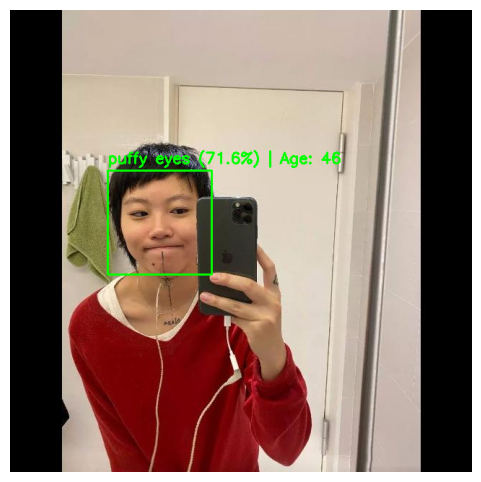


🟢 Prediction Result
Skin Problem: puffy eyes
Confidence : 71.56%
Estimated Age: 46


In [ ]:

cls = random.choice(CLASS_NAMES)
img_name = random.choice(os.listdir(os.path.join(DATASET_ROOT, cls)))
test_img = os.path.join(DATASET_ROOT, cls, img_name)

print("Testing Image:", test_img)
analyze_skin(test_img)


Testing Image: DATASET-20251202T142134Z-1-001/DATASET\wrinkles\Image_61.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


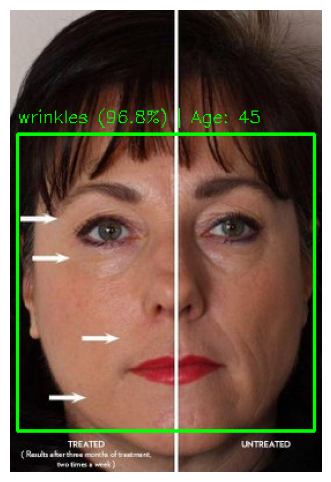


 Prediction Result
Skin Problem: wrinkles
Confidence : 96.81%
Estimated Age: 45


In [162]:

cls = random.choice(CLASS_NAMES)
img_name = random.choice(os.listdir(os.path.join(DATASET_ROOT, cls)))
test_img = os.path.join(DATASET_ROOT, cls, img_name)

print("Testing Image:", test_img)
analyze_skin(test_img)
